# サイン操舵
0.5Hzでサイン操舵し計測

In [1]:
from jetracer.nvidia_racecar import NvidiaRacecar
type = "TT02" # "OPTION", "TT02"
car = NvidiaRacecar(type)

In [2]:
import smbus
import math
from time import sleep
import time

import numpy as np
import matplotlib.pyplot as plt

DEV_ADDR = 0x68

ACCEL_XOUT = 0x3b
ACCEL_YOUT = 0x3d
ACCEL_ZOUT = 0x3f
TEMP_OUT = 0x41
GYRO_XOUT = 0x43
GYRO_YOUT = 0x45
GYRO_ZOUT = 0x47

PWR_MGMT_1 = 0x6b
PWR_MGMT_2 = 0x6c   

bus = smbus.SMBus(1)
bus.write_byte_data(DEV_ADDR, PWR_MGMT_1, 0)

def read_word(adr):
    high = bus.read_byte_data(DEV_ADDR, adr)
    low = bus.read_byte_data(DEV_ADDR, adr+1)
    val = (high << 8) + low
    return val

def read_word_sensor(adr):
    val = read_word(adr)
    if (val >= 0x8000):  return -((65535 - val) + 1)
    else:  return val

def get_temp():
    temp = read_word_sensor(TEMP_OUT)
    x = temp / 340 + 36.53      # data sheet(register map)記載の計算式.
    return x

def getGyro():
    x = read_word_sensor(GYRO_XOUT)/ 131.0
    y = read_word_sensor(GYRO_YOUT)/ 131.0
    z = read_word_sensor(GYRO_ZOUT)/ 131.0
    return [x, y, z]


def getAccel():
    x = read_word_sensor(ACCEL_XOUT)/ 16384.0
    y= read_word_sensor(ACCEL_YOUT)/ 16384.0
    z= read_word_sensor(ACCEL_ZOUT)/ 16384.0
    return [x, y, z]

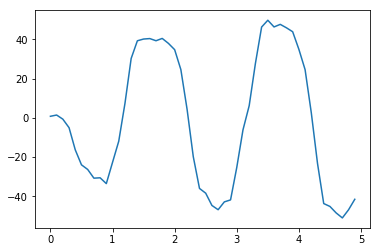

In [6]:
import ipywidgets.widgets as widgets
from IPython.display import display
import time, math

car.steering = 0.0
car.throttle = 0.1
time.sleep(3)

car.steering_gain = -0.65
car.steering_offset = 0.13
car.throttle = 0.32

ff = 10 # サンプリング周波数
fc = 0.5 # 操舵周期
n = 50

yaw=np.zeros(n)
tt=np.zeros(n)

car.steering = 0.0
for i in range(0, 50, 1):
    c = 0.7*math.sin(2*math.pi*i*fc/ff)
    #print("steering: ",c)
    car.steering = c
    
    ax, ay, az = getAccel()
    gx, gy, gz = getGyro()
    #print ("yaw:", gz)
    yaw[i] = gz
    tt[i] = i/ff
    
    time.sleep(1.0/ff)

plt.plot(tt,yaw)
    
car.steering = 0.0
car.throttle = 0.1
